<a href="https://colab.research.google.com/github/Chiaradisanto/Segmentation/blob/main/TestONsensor1_3-patient1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [287]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [288]:
import os

In [289]:

num_train_imgs = len(os.listdir('/gdrive/MyDrive/TEST/TEST-TOTALE/HCM-001/test_images/images'))
num_val_images = len(os.listdir('/gdrive/MyDrive/TEST/TEST-TOTALE/HCM-001/test_masks/masks'))

In [290]:
num_val_images

255

In [291]:

num_train_imgs

255

In [292]:

import os
from IPython.core.completer import time
from skimage.transform import resize
from natsort import natsorted
from tensorflow.keras.preprocessing.image import (
    array_to_img,
    img_to_array,
    load_img,
)
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import pickle
from tqdm import tqdm

In [293]:

import os
from IPython.core.completer import time
from skimage.transform import resize
from natsort import natsorted
from tensorflow.keras.preprocessing.image import (
    array_to_img,
    img_to_array,
    load_img,
)
from tensorflow.keras import layers
import tensorflow as tf
import numpy as np
import pickle
from tqdm import tqdm


class DataLoader:
    def __init__(
        self,
        *,
        data_path,
        paziente: str,
        timesteps: int = 3,
        batch_size: int = 225,
        squeeze=False,
        augmentation=False,
        shuffle=False,
        sort_method="number",  # oppure "number"
        resize_to=256,
    ):
        self.shuffle = shuffle
        self.do_augmentation = augmentation
        self.timesteps = timesteps
        self.batch_size = batch_size
        self.squeeze = squeeze
        self.data_path = data_path
        train_img_file_names = [
            os.path.join(data_path, fn)
            for fn in os.listdir(
                data_path
            )  # os.listdir(os.path.join(data_folder, "train_images", "images"))
        ]

        def sort_by_number(file_names: list):
            return sorted(file_names, key=lambda x: int(x.split("/")[-1].split(".")[0]))

        train_img_file_names = (
            natsorted(train_img_file_names)
            if sort_method == "natsort"
            else sort_by_number(train_img_file_names)
        )
        self.filenames = train_img_file_names
        # train_img_file_names.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
        train_mask_file_names = [
            fn.replace("images", "masks") for fn in train_img_file_names
        ]
        if not os.path.exists(f"{paziente}imgs.pickle"):
            self.imgs = (
                np.array(
                    [
                        resize(
                            img_to_array(load_img(fn, color_mode="grayscale")),
                            (resize_to, resize_to),
                        )
                        for fn in train_img_file_names
                    ]
                )
                / 255
            )
            with open(f"{paziente}imgs.pickle", "wb") as f:
                pickle.dump(self.imgs, f)
        else:
            print("Loading imgs from pickle")
            with open(f"{paziente}imgs.pickle", "rb") as f:
                self.imgs = pickle.load(f)
        if not os.path.exists(f"{paziente}_masks.pickle"):
            self.masks = (
                np.array(
                    [
                        resize(
                            img_to_array(load_img(fn, color_mode="grayscale")),
                            (resize_to, resize_to),
                        )
                        for fn in train_mask_file_names
                    ]
                )
                / 255
                > 0.5
            ).astype(float)
            with open(f"{paziente}masks.pickle", "wb") as f:
                pickle.dump(self.masks, f)
        else:
            print("Loading masks from pickle file")
            with open(f"{paziente}masks.pickle", "rb") as f:
                self.masks = pickle.load(f)

        self.augmentation = tf.keras.Sequential(
            [
                layers.RandomFlip("horizontal_and_vertical"),
                layers.RandomRotation(0.2),
            ]
        )
        self.index = 0

    def __iter__(self):
        return self

    def __next__(self):
        """
        xs = []
        ys = []
        if self.shuffle:
            for _ in range(self.batch_size):
                index = np.random.randint(0, len(self.imgs) - self.timesteps)
                xs.append(self.imgs[index : index + self.timesteps])
                ys.append(self.masks[index + self.timesteps])
        else:
            # i = np.random.randint(0, len(self.imgs) - self.timesteps - self.batch_size)
            if self.index >= len(self.imgs) - self.timesteps - self.batch_size:
                self.index = 0
                raise StopIteration
            xs = [
                self.imgs[i * self.timesteps : (i + 1) * self.timesteps]
                for i in range(self.index, self.batch_size // self.timesteps)
            ]
            ys = [
                self.masks[(i + 1) * self.timesteps]
                for i in range(self.index, self.batch_size // self.timesteps)
            ]
            self.index += self.batch_size // self.timesteps
            x, y = np.array(xs), np.array(ys)
        x = x.squeeze(-1).transpose(0, 2, 3, 1)
        xy = tf.concat((x, y), axis=-1)
        if self.do_augmentation:
            xy = self.augmentation(xy)
        x = xy[:, :, :, :3]
        y = xy[:, :, :, 3:]
        if not self.squeeze:
            x = tf.transpose(x, perm=(0, 3, 1, 2))[..., None]
            y = tf.expand_dims(y, 1)
        return x, y
        """
        # return self.imgs, self.masks
        imgs = np.stack(
            [
                self.imgs[i : i + 3]
                for i in range(0, len(self.imgs), 3)
                if i + 3 < len(self.imgs)
            ]
        )
        masks = np.stack(
            [
                self.masks[i, None]
                for i in range(0, len(self.masks), 3)
                if i + 3 < len(self.masks)
            ]
        )
        return imgs, masks



In [294]:
val_loader = DataLoader(
        data_path=os.path.join(
                   "/gdrive/MyDrive/TEST/TEST-TOTALE/HCM-001",
        "test_images", "images"

        ),
        paziente='1',
        batch_size=255,
        squeeze=False,
        augmentation=False,
        shuffle=False,
        sort_method="number",
)

Loading imgs from pickle


In [295]:
a, b = val_loader.__next__()

In [296]:
a.shape

(84, 3, 256, 256, 1)

In [297]:
b.shape

(84, 1, 256, 256, 1)

In [298]:
from matplotlib import pyplot as plt

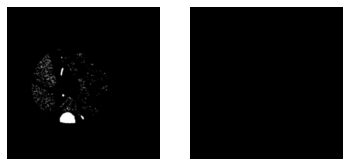

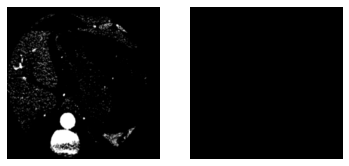

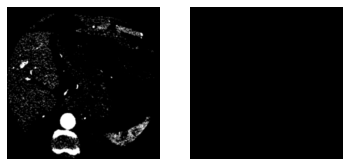

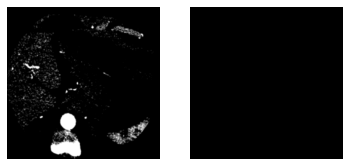

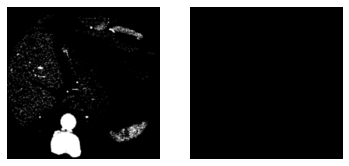

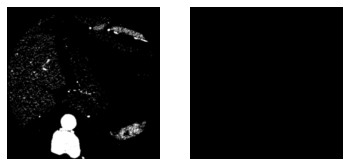

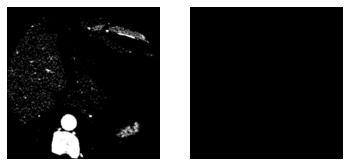

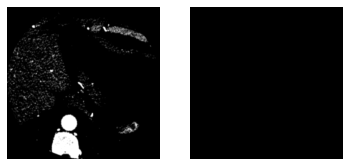

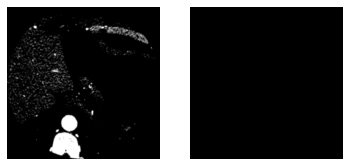

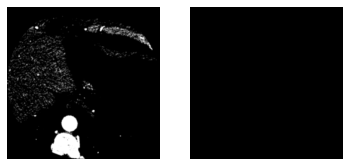

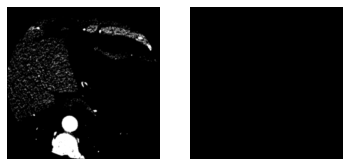

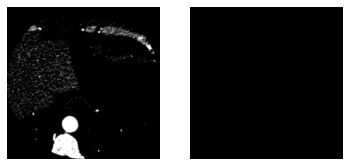

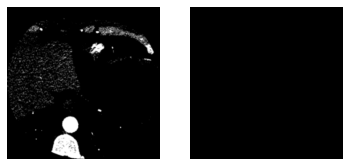

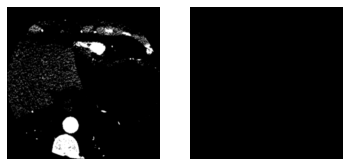

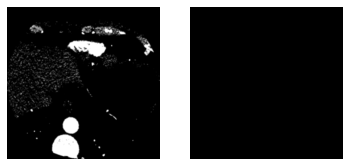

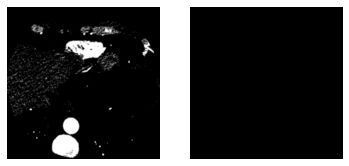

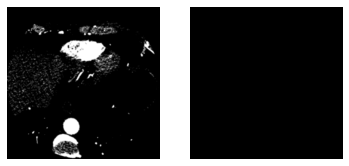

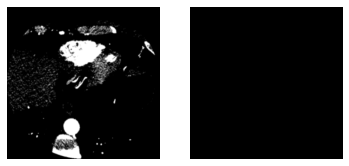

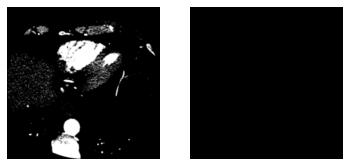

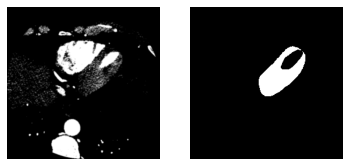

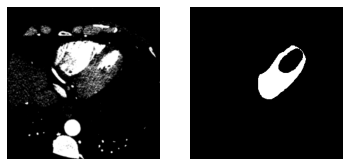

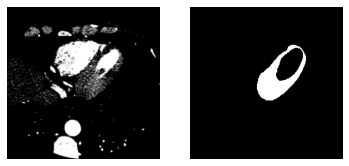

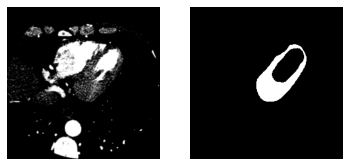

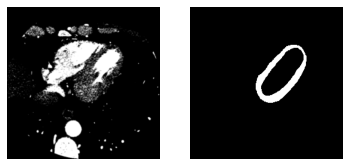

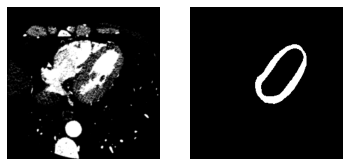

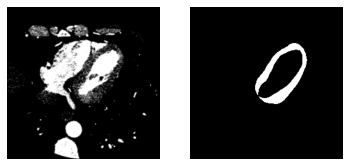

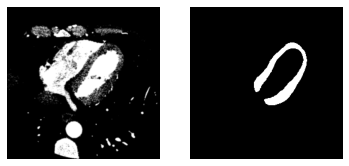

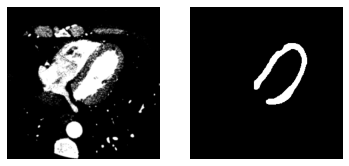

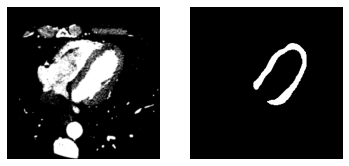

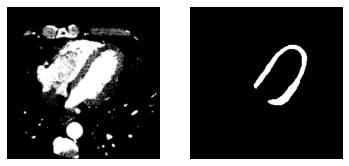

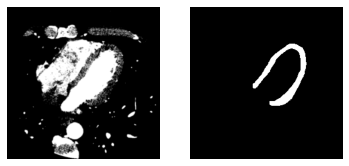

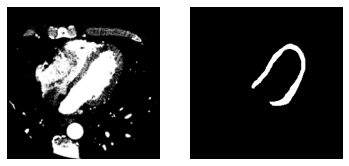

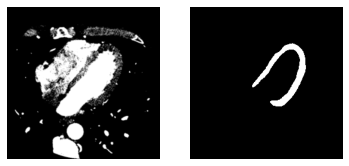

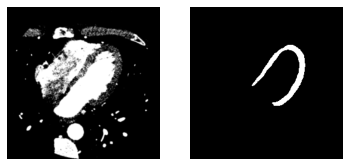

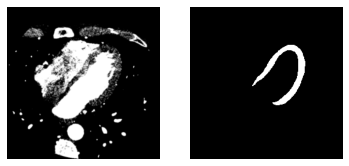

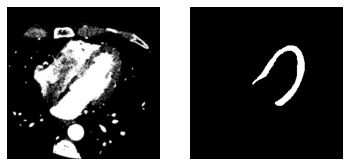

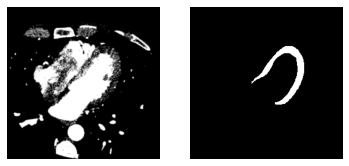

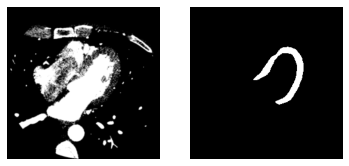

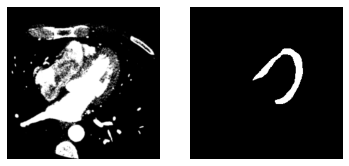

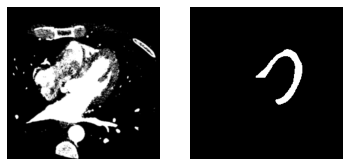

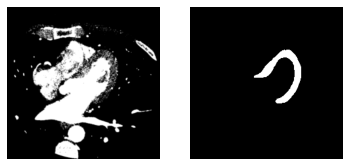

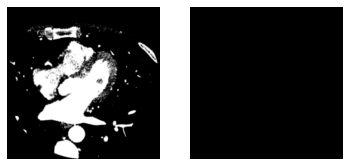

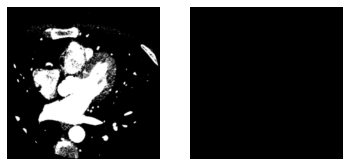

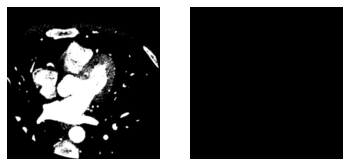

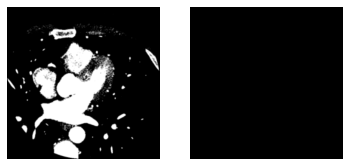

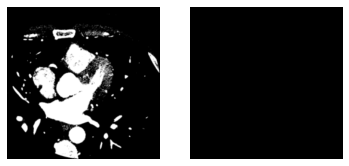

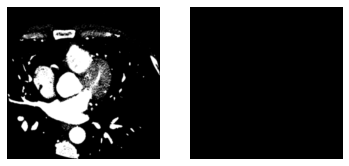

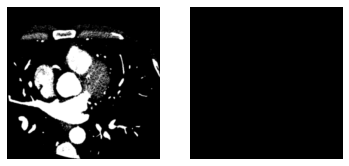

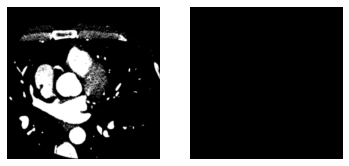

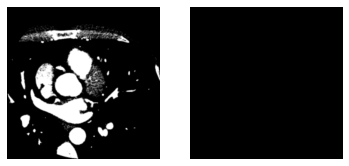

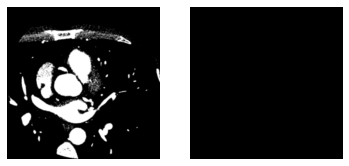

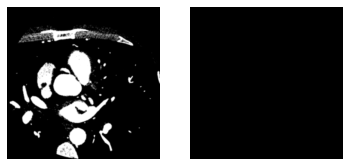

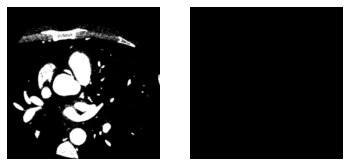

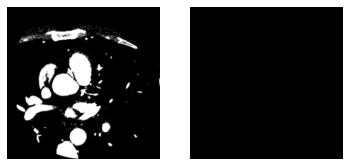

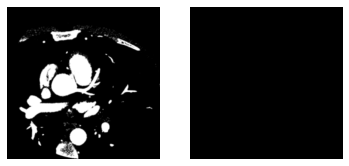

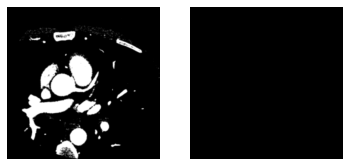

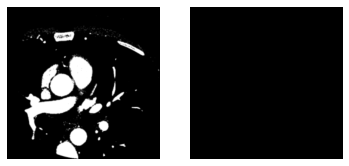

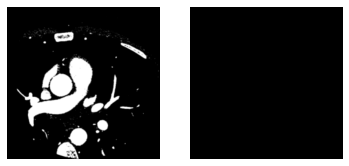

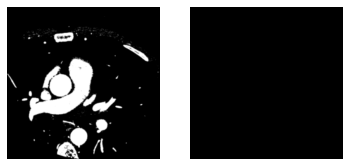

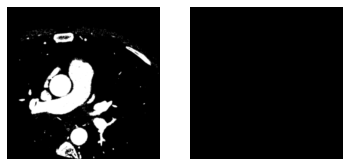

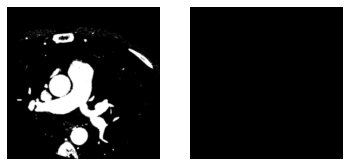

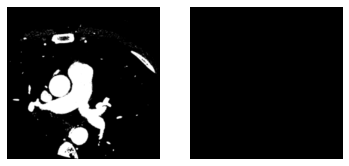

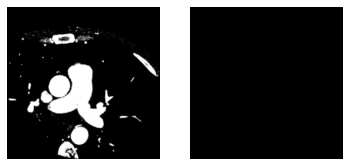

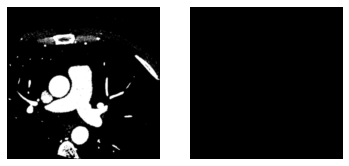

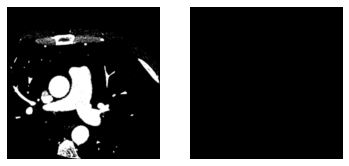

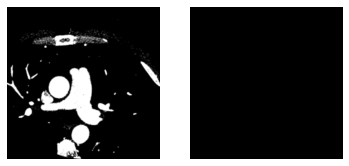

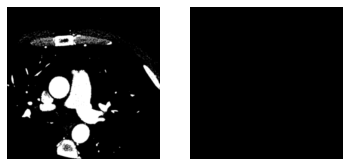

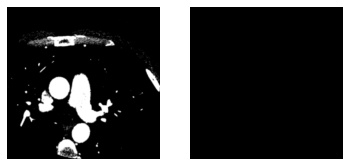

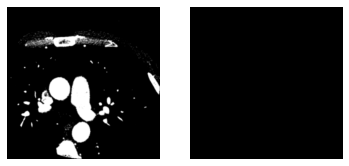

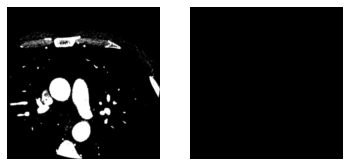

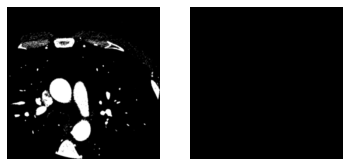

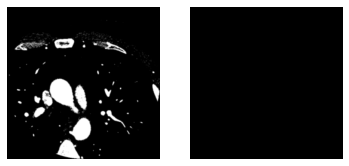

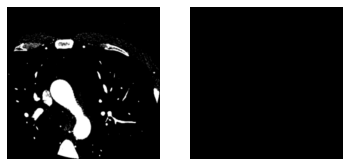

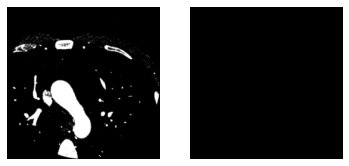

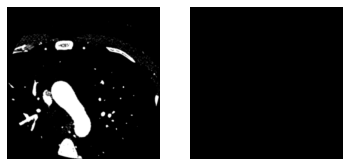

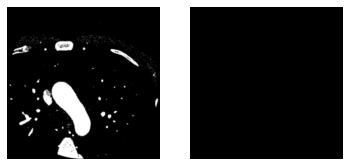

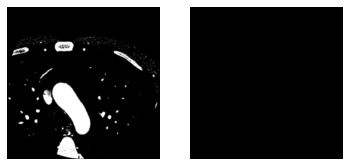

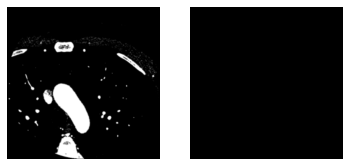

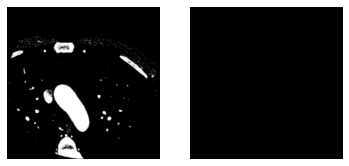

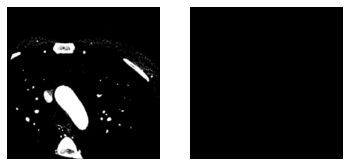

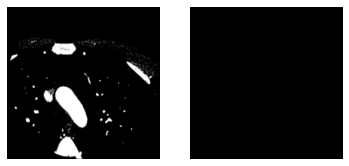

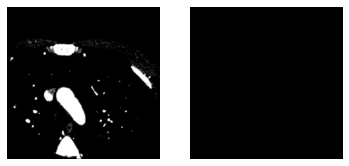

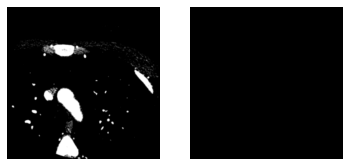

In [299]:

for i in range(0,a.shape[0]-1):
    image = a[i,0,:,:,0]
    #mask = np.argmax(y[i], axis=2)
    mask= b[i,0,:,:,0]
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()

In [300]:
#Load previously saved model
from keras.models import load_model
model = load_model("/gdrive/MyDrive/TEST/Sensor30.unet-1111-5e-5-noaugonvalidation-relu-recurrentdropout0.2-3blocks-batch12-convlstm.savethebest (1).h5", compile=False)

1/1 [==============================] - 0s 24ms/step


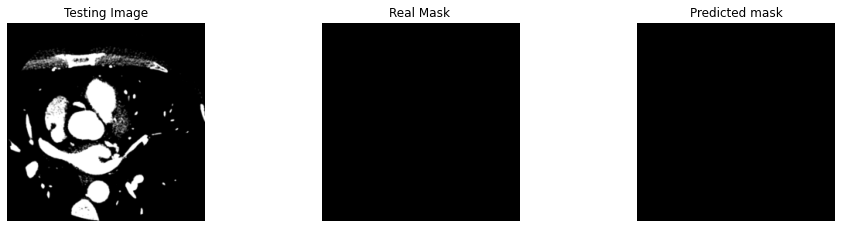

In [321]:
import random
test_img_number = random.randint(30, 50)
test_img = a[test_img_number]
ground_truth=b[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)

prediction = (model.predict(test_img_input)[0,0,:,:,0] > 0.5).astype(np.uint8)
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.axis('off')
plt.title('Testing Image')
plt.imshow(test_img[0,:,:,0], cmap='gray')


plt.subplot(232)
plt.title('Real Mask ')
plt.axis('off')
plt.imshow(ground_truth[0,:,:,0], cmap='gray')
plt.subplot(233)
plt.axis('off')
plt.title('Predicted mask')
plt.imshow(prediction, cmap='gray')

plt.show()

In [302]:
#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[0,:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())


Mean IoU = 0.8361925


In [303]:

import pandas as pd

IoU_values = []
for img in range(0, a.shape[0]):
    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,0,:,:,0]> 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[0,:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)
    

print('Number of masks is : ',len(IoU_values))
df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)

1/1 [==============================] - 0s 23ms/step
1.0
1/1 [==============================] - 0s 24ms/step
1.0
1/1 [==============================] - 0s 23ms/step
1.0
1/1 [==============================] - 0s 25ms/step
1.0
1/1 [==============================] - 0s 25ms/step
1.0
1/1 [==============================] - 0s 23ms/step
1.0
1/1 [==============================] - 0s 22ms/step
1.0
1/1 [==============================] - 0s 27ms/step
1.0
1/1 [==============================] - 0s 23ms/step
1.0
1/1 [==============================] - 0s 27ms/step
1.0
1/1 [==============================] - 0s 23ms/step
1.0
1/1 [==============================] - 0s 22ms/step
1.0
1/1 [==============================] - 0s 24ms/step
1.0
1/1 [==============================] - 0s 22ms/step
1.0
1/1 [==============================] - 0s 25ms/step
1.0
1/1 [==============================] - 0s 25ms/step
1.0
1/1 [==============================] - 0s 25ms/step
1.0
1/1 [==============================] - 0s 25ms/s

In [304]:

import pandas as pd
IoU_values = []
for img in range(0, a.shape[0]):
    temp_img = a[img]
    ground_truth=b[img]
    if tf.math.reduce_max(ground_truth)>0:
      temp_img_input=np.expand_dims(temp_img, 0)
      prediction = (model.predict(temp_img_input)[0,0,:,:,0]> 0.5).astype(np.uint8)
      
      IoU = MeanIoU(num_classes=n_classes)
      IoU.update_state(ground_truth[0,:,:,0], prediction)
      IoU = IoU.result().numpy()
      IoU_values.append(IoU)

      print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("number of black masks is.: ", len(IoU_values))
print("Mean IoU is: ", mean_IoU)

1/1 [==============================] - 0s 26ms/step
0.47634888
1/1 [==============================] - 0s 23ms/step
0.47695923
1/1 [==============================] - 0s 27ms/step
0.47764587
1/1 [==============================] - 0s 24ms/step
0.4771881
1/1 [==============================] - 0s 22ms/step
0.59056777
1/1 [==============================] - 0s 27ms/step
0.58051926
1/1 [==============================] - 0s 23ms/step
0.76479113
1/1 [==============================] - 0s 25ms/step
0.8900088
1/1 [==============================] - 0s 25ms/step
0.8947061
1/1 [==============================] - 0s 23ms/step
0.88718307
1/1 [==============================] - 0s 25ms/step
0.87480664
1/1 [==============================] - 0s 24ms/step
0.8859341
1/1 [==============================] - 0s 22ms/step
0.8361925
1/1 [==============================] - 0s 48ms/step
0.86159027
1/1 [==============================] - 0s 22ms/step
0.86758196
1/1 [==============================] - 0s 22ms/step
0.844168

In [ ]:
class DataLoader:
    def __init__(
        self,
        *,
        data_path,
        timesteps: int = 3,
        batch_size: int = 255,
        squeeze=False,
        augmentation=False,
        sort_method="natsort" # oppure "number"
    ):

        self.do_augmentation = augmentation
        self.timesteps = timesteps
        self.batch_size = 255
        self.squeeze = squeeze
        self.data_path = data_path
        train_img_file_names = [
            os.path.join(data_path, fn)
            for fn in os.listdir(
                data_path
            )  # os.listdir(os.path.join(data_folder, "train_images", "images"))
        ]
        def sort_by_number(file_names:str):
            return sorted(names, key=lambda x: int(x.split('/')[-1].split('.')[0]))

        train_img_file_names = natsorted(train_img_file_names) if sort_method == "natsort" else sort_by_number(train_img_file_names)
        # train_img_file_names.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
        train_mask_file_names = [
            fn.replace("images", "masks") for fn in train_img_file_names
        ]
        self.imgs = (
            np.array(
                [
                    img_to_array(load_img(fn, color_mode="grayscale", target_size=(256,256)))
                    for fn in train_img_file_names
                ]
            )
            / 255
        )
        self.masks = (
            np.array(
                [
                    img_to_array(load_img(fn, color_mode="grayscale",target_size=(256,256)))
                    for fn in train_mask_file_names
                ]
            )
            / 255
            > 0.5
        ).astype(float)
        self.augmentation = tf.keras.Sequential(
            [
                layers.RandomFlip("horizontal_and_vertical"),
                layers.RandomRotation(0.2),
            ]
        )

    def __iter__(self):
        return self

    def __next__(self):
        xs = []
        ys = []
        for _ in range(self.batch_size):
            index = np.random.randint(0, len(self.imgs) - self.timesteps)
            xs.append(self.imgs[index : index + self.timesteps])
            ys.append(self.masks[index + self.timesteps])
        x, y = np.array(xs), np.array(ys)
        x = x.squeeze(-1).transpose(0, 2, 3, 1)
        xy = tf.concat((x, y), axis=-1)
        if self.do_augmentation:
            xy = self.augmentation(xy)

        x = xy[:, :, :, :3]
        y = xy[:, :, :, 3:]
        if not self.squeeze:
            x = tf.transpose(x, perm=(0, 3, 1, 2))[..., None]
            y = tf.expand_dims(y, 1)
        # if not tf.reduce_all(y[0] == 0):
        #    ipdb.set_trace()
        return x, y

In [ ]:
val_loader = DataLoader(
    data_path=os.path.join(
                   "/gdrive/MyDrive/TESI/TEST/TEST-TOTALE/HCM-001",
        "test_images", "images"
    ),
    batch_size=255,
    squeeze=False,
    augmentation=False,
)

In [ ]:
a, b = val_loader.__next__()

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
a.shape

TensorShape([255, 3, 256, 256, 1])

In [ ]:
b.shape

TensorShape([255, 1, 256, 256, 1])

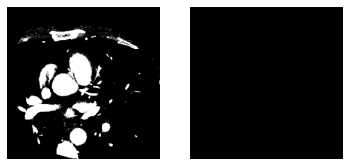

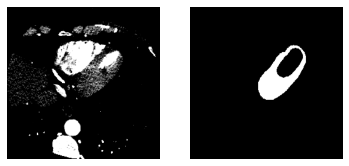

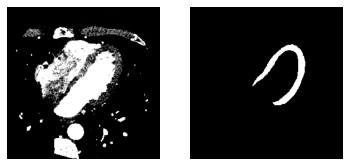

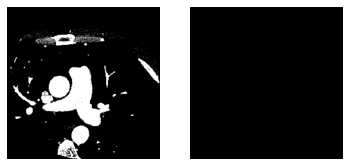

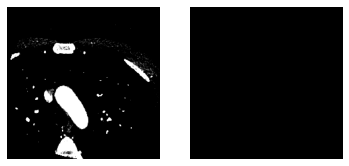

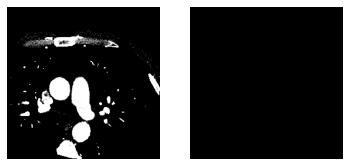

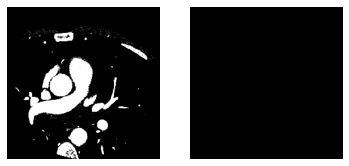

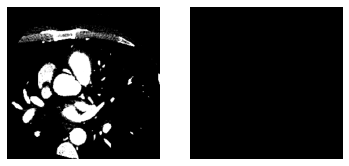

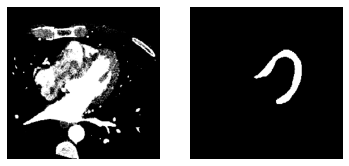

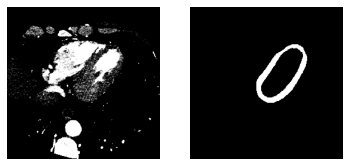

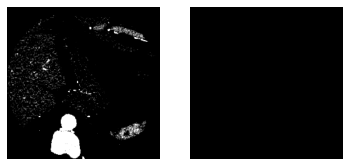

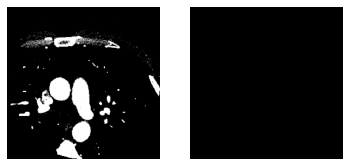

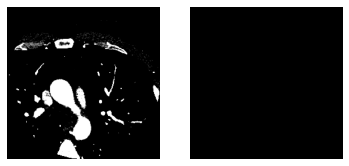

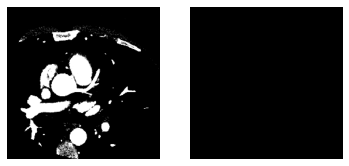

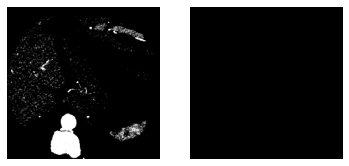

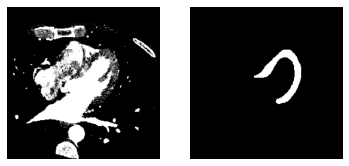

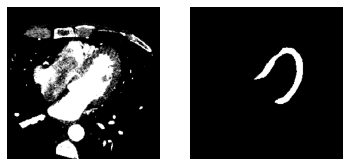

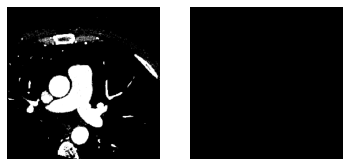

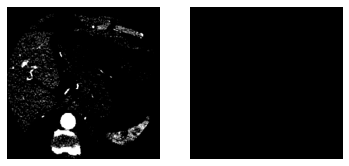

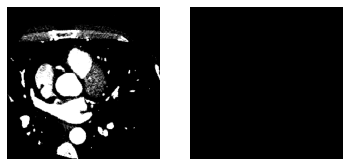

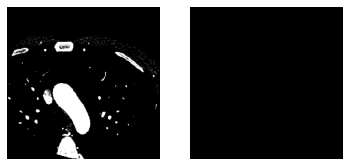

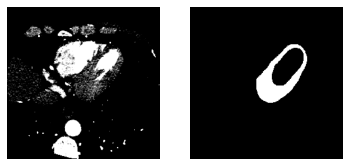

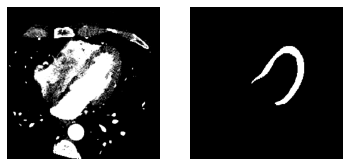

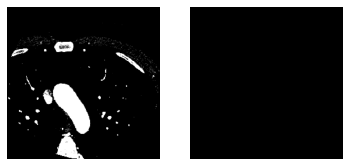

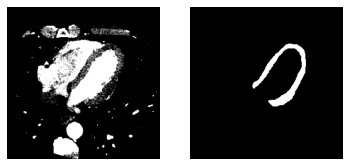

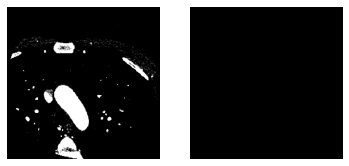

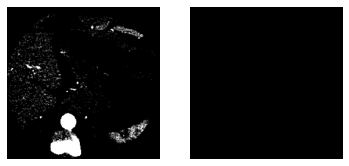

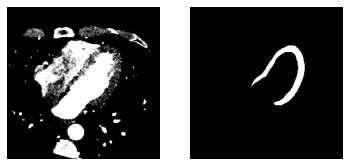

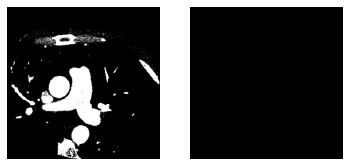

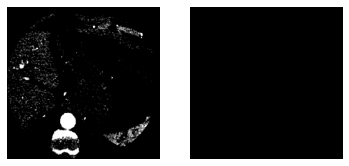

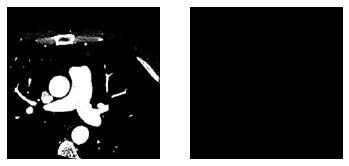

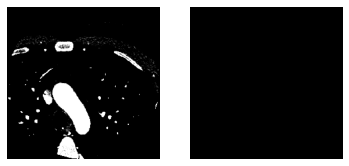

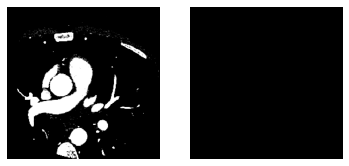

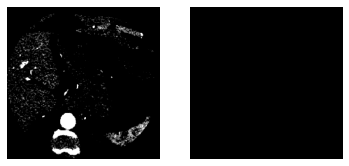

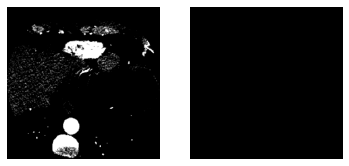

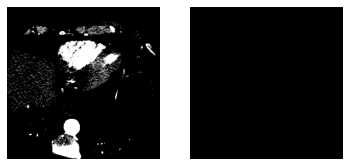

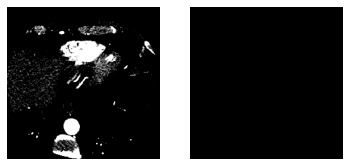

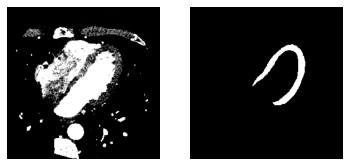

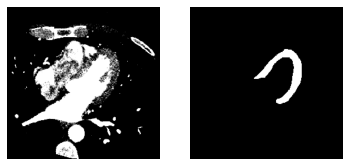

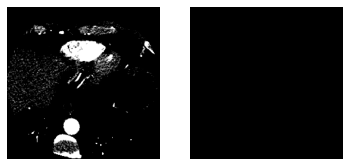

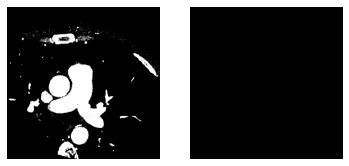

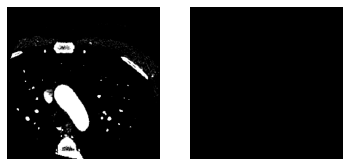

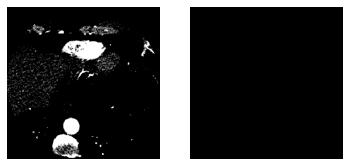

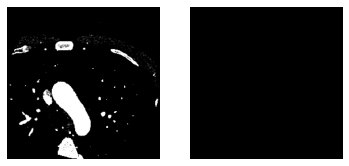

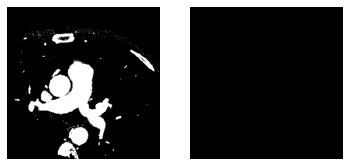

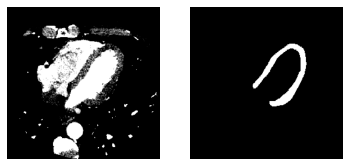

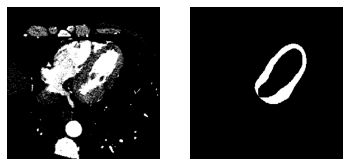

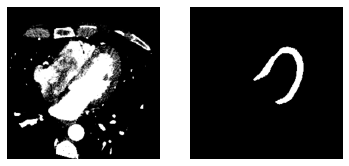

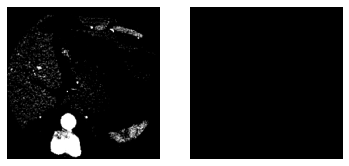

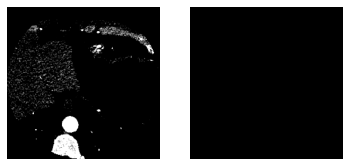

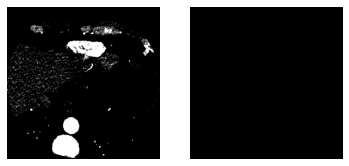

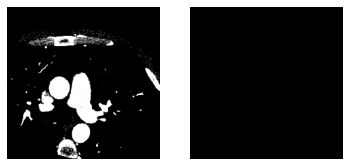

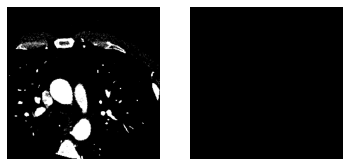

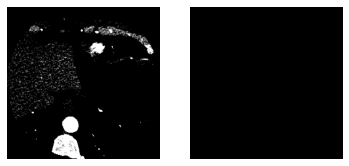

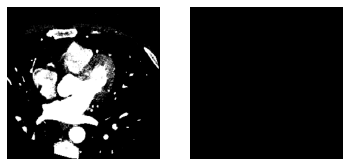

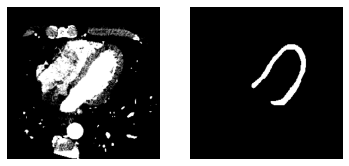

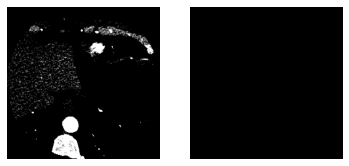

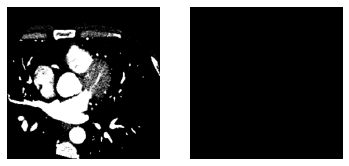

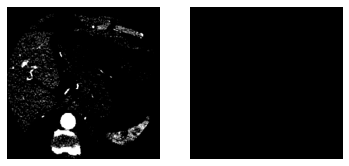

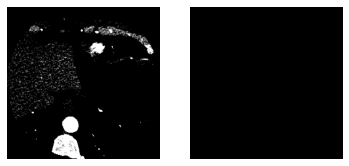

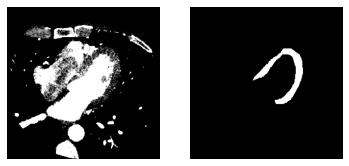

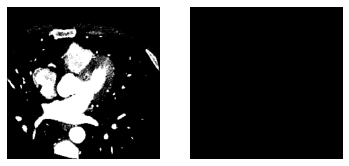

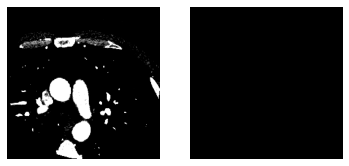

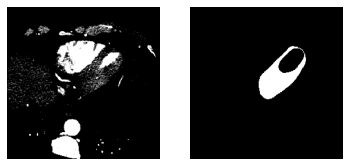

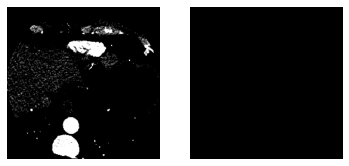

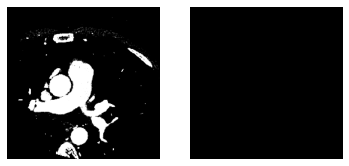

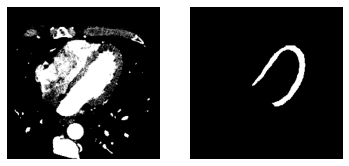

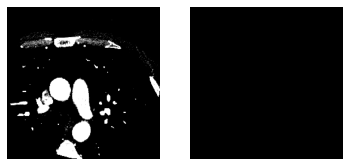

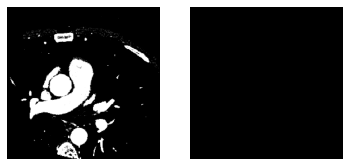

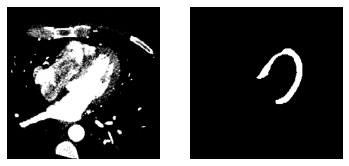

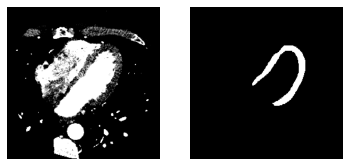

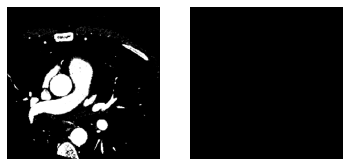

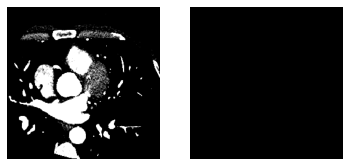

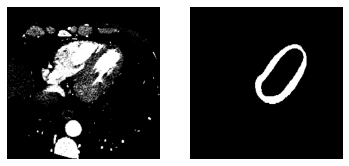

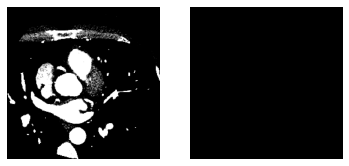

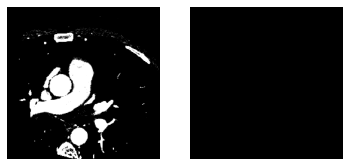

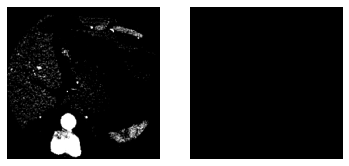

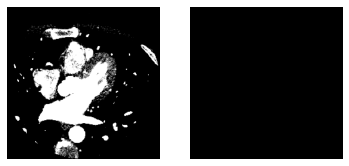

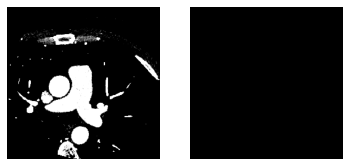

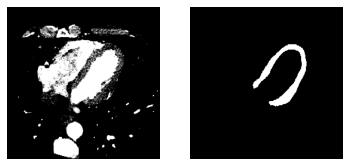

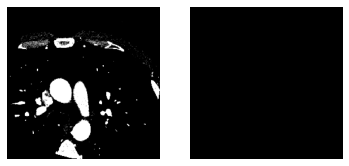

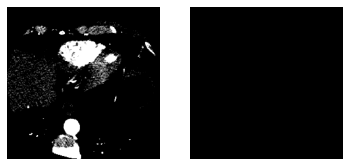

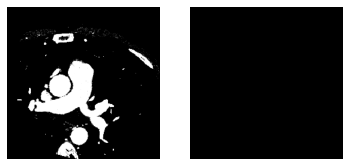

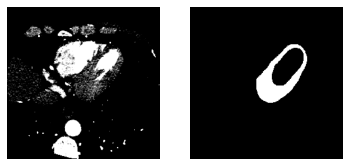

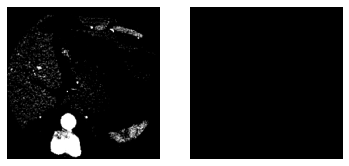

In [ ]:

for i in range(0,85):
    image = a[i,0,:,:,0]
    #mask = np.argmax(y[i], axis=2)
    mask= b[i,0,:,:,0]
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()

In [ ]:
import random
test_img_number = random.randint(20, 30)
test_img = a[test_img_number]
ground_truth=b[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)

prediction = (model.predict(test_img_input)[0,0,:,:,0] > 0.5).astype(np.uint8)
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.axis('off')
plt.title('Testing Image')
plt.imshow(test_img[0,:,:,0], cmap='gray')


plt.subplot(232)
plt.title('Real Mask ')
plt.axis('off')
plt.imshow(ground_truth[0,:,:,0], cmap='gray')
plt.subplot(233)
plt.axis('off')
plt.title('Predicted mask')
plt.imshow(prediction, cmap='gray')

plt.show()

In [ ]:
#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[0,:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())


Mean IoU = 0.49222565


In [ ]:

import pandas as pd

IoU_values = []
for img in range(0, a.shape[0]):
    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,0,:,:,0]> 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[0,:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)

1/1 [==============================] - 1s 1s/step
1.0
1/1 [==============================] - 1s 1s/step
0.47725677
1/1 [==============================] - 1s 1s/step
0.51587534
1/1 [==============================] - 1s 1s/step
1.0
1/1 [==============================] - 1s 1s/step
1.0
1/1 [==============================] - 1s 1s/step
1.0
1/1 [==============================] - 1s 1s/step
1.0
1/1 [==============================] - 1s 1s/step
1.0
1/1 [==============================] - 1s 1s/step
0.48557281
1/1 [==============================] - 1s 1s/step
0.48368073
1/1 [==============================] - 1s 1s/step
0.49785614
1/1 [==============================] - 1s 1s/step
1.0
1/1 [==============================] - 1s 1s/step
1.0
1/1 [==============================] - 1s 1s/step
1.0
1/1 [==============================] - 1s 1s/step
0.4956894
1/1 [==============================] - 1s 1s/step
0.4855652
1/1 [==============================] - 2s 2s/step
0.48627472
1/1 [=======================

In [ ]:

import pandas as pd

IoU_values = []
for img in range(0, a.shape[0]):
    temp_img = a[img]
    ground_truth=b[img]
    if tf.math.reduce_max(ground_truth)>0:
      temp_img_input=np.expand_dims(temp_img, 0)
      prediction = (model.predict(temp_img_input)[0,0,:,:,0]> 0.5).astype(np.uint8)
      
      IoU = MeanIoU(num_classes=n_classes)
      IoU.update_state(ground_truth[0,:,:,0], prediction)
      IoU = IoU.result().numpy()
      IoU_values.append(IoU)

      print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("number of black masks is.: ", len(IoU_values))
print("Mean IoU is: ", mean_IoU)

1/1 [==============================] - 1s 1s/step
0.47725677
1/1 [==============================] - 1s 1s/step
0.51587534
1/1 [==============================] - 1s 1s/step
0.48557281
1/1 [==============================] - 1s 1s/step
0.48368073
1/1 [==============================] - 1s 1s/step
0.4855652
1/1 [==============================] - 1s 1s/step
0.48627472
1/1 [==============================] - 1s 1s/step
0.47688293
1/1 [==============================] - 1s 1s/step
0.485878
1/1 [==============================] - 1s 1s/step
0.73252934
1/1 [==============================] - 1s 1s/step
0.4854126
1/1 [==============================] - 1s 1s/step
0.51587534
1/1 [==============================] - 1s 1s/step
0.4848938
1/1 [==============================] - 1s 1s/step
0.73218817
1/1 [==============================] - 1s 1s/step
0.4879658
1/1 [==============================] - 1s 1s/step
0.48568726
1/1 [==============================] - 1s 1s/step
0.56464523
1/1 [=========================